## Setting up/formatting the dataset

In this notebook, we perform the following tasks:

- Consolidate and merge different datasets.
- Combine scraped data.
- Generate the dataset for training our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import RocCurveDisplay, recall_score, precision_score, roc_curve, roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
main=pd.read_csv('datasets/all-weeks-global.csv')
movies=pd.read_csv('datasets/bestmovies.csv')
shows=pd.read_csv('datasets/bestshows.csv')
globai=pd.read_csv('datasets/whatwewatch.csv')

In [3]:
main

,week,category,weekly_rank,show_title,season_title,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10,Unnamed: 9,episode_launch_details
0,2024-03-24,Films (English),1,Irish Wish,NaN,40000000,1.5667,25500000.0,2,False,NaN
1,2024-03-24,Films (English),2,Damsel,NaN,35700000,1.8333,19500000.0,3,False,NaN
2,2024-03-24,Films (English),3,Shooter,NaN,11700000,2.0833,5600000.0,5,False,NaN
3,2024-03-24,Films (English),4,Ford v. Ferrari,NaN,11200000,2.5500,4400000.0,2,False,NaN
4,2024-03-24,Films (English),5,The Casagrandes Movie,NaN,5700000,1.4167,4000000.0,1,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5715,2021-07-04,TV (Non-English),6,Elite,Elite: Season 1,10530000,NaN,NaN,1,False,NaN
5716,2021-07-04,TV (Non-English),7,Elite,Elite: Season 3,10200000,NaN,NaN,1,False,NaN
5717,2021-07-04,TV (Non-English),8,Elite,Elite: Season 2,10140000,NaN,NaN,1,False,NaN
5718,2021-07-04,TV (Non-English),9,Katla,Katla: Season 1,9190000,NaN,NaN,1,False,NaN


In [4]:
main['is_staggered_launch']=main['Unnamed: 9']

In [5]:
def strip_season(title):
    return title.split(': Season')[0].strip()
globai['Title'] = globai['Title'].apply(strip_season)

In [6]:
main=main[['week', 'category','show_title', 'weekly_hours_viewed', 'runtime', 'weekly_views', 'cumulative_weeks_in_top_10', 'is_staggered_launch']]
globai=globai[['Title','Available Globally?','Release Date']].set_index('Title')
shows=shows[['TITLE','MAIN_GENRE','SCORE','NUMBER_OF_VOTES', 'MAIN_PRODUCTION', 'NUMBER_OF_SEASONS' ]].set_index('TITLE')
movies=movies[['TITLE','MAIN_GENRE','SCORE','NUMBER_OF_VOTES', 'MAIN_PRODUCTION' ]].set_index('TITLE')
showsmovies = pd.concat([shows, movies], axis=0)

In [7]:
new=main.join(globai, on='show_title', how='left')
comb_df=new.join(showsmovies, on='show_title', how='left')
comb_df.head()

,week,category,show_title,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10,is_staggered_launch,Available Globally?,Release Date,MAIN_GENRE,SCORE,NUMBER_OF_VOTES,MAIN_PRODUCTION,NUMBER_OF_SEASONS
0,2024-03-24,Films (English),Irish Wish,40000000,1.5667,25500000.0,2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-03-24,Films (English),Damsel,35700000,1.8333,19500000.0,3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-03-24,Films (English),Shooter,11700000,2.0833,5600000.0,5,False,No,2016-11-16,war,7.5,35547.0,US,3.0
2,2024-03-24,Films (English),Shooter,11700000,2.0833,5600000.0,5,False,No,2016-11-16,thriller,7.2,329417.0,US,NaN
2,2024-03-24,Films (English),Shooter,11700000,2.0833,5600000.0,5,False,No,2018-06-22,war,7.5,35547.0,US,3.0


In [8]:
#detatching the language from type
comb_df[['type', 'language']] = comb_df['category'].str.split(' \(', expand=True)
comb_df['language'] = comb_df['language'].str.replace(')', '')
comb_df.drop(columns=['category'], inplace=True)

In [9]:
comb_df

,week,show_title,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10,is_staggered_launch,Available Globally?,Release Date,MAIN_GENRE,SCORE,NUMBER_OF_VOTES,MAIN_PRODUCTION,NUMBER_OF_SEASONS,type,language
0,2024-03-24,Irish Wish,40000000,1.5667,25500000.0,2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Films,English
1,2024-03-24,Damsel,35700000,1.8333,19500000.0,3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Films,English
2,2024-03-24,Shooter,11700000,2.0833,5600000.0,5,False,No,2016-11-16,war,7.5,35547.0,US,3.0,Films,English
2,2024-03-24,Shooter,11700000,2.0833,5600000.0,5,False,No,2016-11-16,thriller,7.2,329417.0,US,NaN,Films,English
2,2024-03-24,Shooter,11700000,2.0833,5600000.0,5,False,No,2018-06-22,war,7.5,35547.0,US,3.0,Films,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5717,2021-07-04,Elite,10140000,NaN,NaN,1,False,Yes,2020-03-13,NaN,NaN,NaN,NaN,NaN,TV,Non-English
5717,2021-07-04,Elite,10140000,NaN,NaN,1,False,Yes,2021-06-18,NaN,NaN,NaN,NaN,NaN,TV,Non-English
5718,2021-07-04,Katla,9190000,NaN,NaN,1,False,Yes,2021-06-17,NaN,NaN,NaN,NaN,NaN,TV,Non-English
5719,2021-07-04,Record of Ragnarok,9140000,NaN,NaN,1,False,No,2023-01-26,NaN,NaN,NaN,NaN,NaN,TV,Non-English


In [10]:
comb_df['Release Date'] = pd.to_datetime(comb_df['Release Date'])

In [11]:
grouped_df = comb_df.groupby('show_title').agg({
    'type': lambda x: x.mode().iat[0] if not x.empty else None,
    'weekly_hours_viewed': 'mean',
    'weekly_views': 'mean',
    'cumulative_weeks_in_top_10': 'max',
    'runtime': 'mean',
    'NUMBER_OF_SEASONS': 'max',
    'language': lambda x: x.mode().iat[0] if not x.empty else None,
    'is_staggered_launch': lambda x: x.mode().iat[0] if not x.empty else None,
    'Available Globally?': lambda x: x.dropna().mode().iat[0] if not x.dropna().empty else None,
    'Release Date': 'min',
    'MAIN_GENRE': lambda x: list(set(x)) if not x.isnull().all() else None,
    'SCORE': 'mean',
    'NUMBER_OF_VOTES': 'mean',
    'MAIN_PRODUCTION': lambda x: x.dropna().mode().iat[0] if not x.dropna().empty else None,
    'week': 'max',
})
grouped_df.reset_index(inplace=True)

In [12]:
grouped_df.columns = [column.lower().replace(' ', '_') for column in grouped_df.columns]
grouped_df.rename(columns={'main_genre': 'genre', 'available_globally?': 'available_globally'}, inplace=True)
grouped_df

,show_title,type,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,language,is_staggered_launch,available_globally,release_date,genre,score,number_of_votes,main_production,week
0,'83,Films,6.825000e+06,NaN,2,NaN,NaN,Non-English,False,No,NaT,None,NaN,NaN,None,2022-04-03
1,10 Days of a Bad Man,Films,6.900000e+06,3300000.0,2,2.0667,NaN,Non-English,False,None,NaT,None,NaN,NaN,None,2023-08-27
2,10 Days of a Good Man,Films,7.415000e+06,NaN,2,NaN,NaN,Non-English,False,None,NaT,None,NaN,NaN,None,2023-03-12
3,1000 Miles from Christmas,Films,6.795000e+06,NaN,2,NaN,NaN,Non-English,False,None,NaT,None,NaN,NaN,None,2022-01-02
4,12 Strong,Films,8.210000e+06,NaN,2,NaN,NaN,English,False,No,NaT,None,NaN,NaN,None,2022-07-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,maboroshi,Films,2.400000e+06,1300000.0,1,1.8500,NaN,Non-English,False,None,NaT,None,NaN,NaN,None,2024-01-21
1861,¡Que viva México!,Films,1.249250e+07,NaN,4,NaN,NaN,Non-English,False,Yes,2023-05-11,None,NaN,NaN,None,2023-06-04
1862,Ìjọ̀gbọ̀n,Films,4.950000e+06,2550000.0,2,1.9333,NaN,Non-English,False,None,NaT,None,NaN,NaN,None,2023-10-22
1863,أصحاب ...ولا أعزّ,Films,2.910000e+06,NaN,3,NaN,NaN,Non-English,False,No,2022-01-20,None,NaN,NaN,None,2022-02-06


SINCE THERE ARE ONLY 1800 DATA POINTS I SAW WE JUST SCRAPE FOR ALL OF THEM AND THEN WE CAN GET THE TOMATOMETER AND AUDIENCE SCORE FOR ALL

In [13]:
grouped_df.drop(columns=['score', 'number_of_votes'], inplace=True)
grouped_df.loc[:, 'genre'] = np.nan

In [14]:
grouped_df

,show_title,type,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,language,is_staggered_launch,available_globally,release_date,genre,main_production,week
0,'83,Films,6.825000e+06,NaN,2,NaN,NaN,Non-English,False,No,NaT,NaN,None,2022-04-03
1,10 Days of a Bad Man,Films,6.900000e+06,3300000.0,2,2.0667,NaN,Non-English,False,None,NaT,NaN,None,2023-08-27
2,10 Days of a Good Man,Films,7.415000e+06,NaN,2,NaN,NaN,Non-English,False,None,NaT,NaN,None,2023-03-12
3,1000 Miles from Christmas,Films,6.795000e+06,NaN,2,NaN,NaN,Non-English,False,None,NaT,NaN,None,2022-01-02
4,12 Strong,Films,8.210000e+06,NaN,2,NaN,NaN,English,False,No,NaT,NaN,None,2022-07-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,maboroshi,Films,2.400000e+06,1300000.0,1,1.8500,NaN,Non-English,False,None,NaT,NaN,None,2024-01-21
1861,¡Que viva México!,Films,1.249250e+07,NaN,4,NaN,NaN,Non-English,False,Yes,2023-05-11,NaN,None,2023-06-04
1862,Ìjọ̀gbọ̀n,Films,4.950000e+06,2550000.0,2,1.9333,NaN,Non-English,False,None,NaT,NaN,None,2023-10-22
1863,أصحاب ...ولا أعزّ,Films,2.910000e+06,NaN,3,NaN,NaN,Non-English,False,No,2022-01-20,NaN,None,2022-02-06


In [15]:
#exporting grouped_df to get genres + scores via scraping
grouped_df.to_csv('datasets/netflix.csv', index=False)

### Data Exploration

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


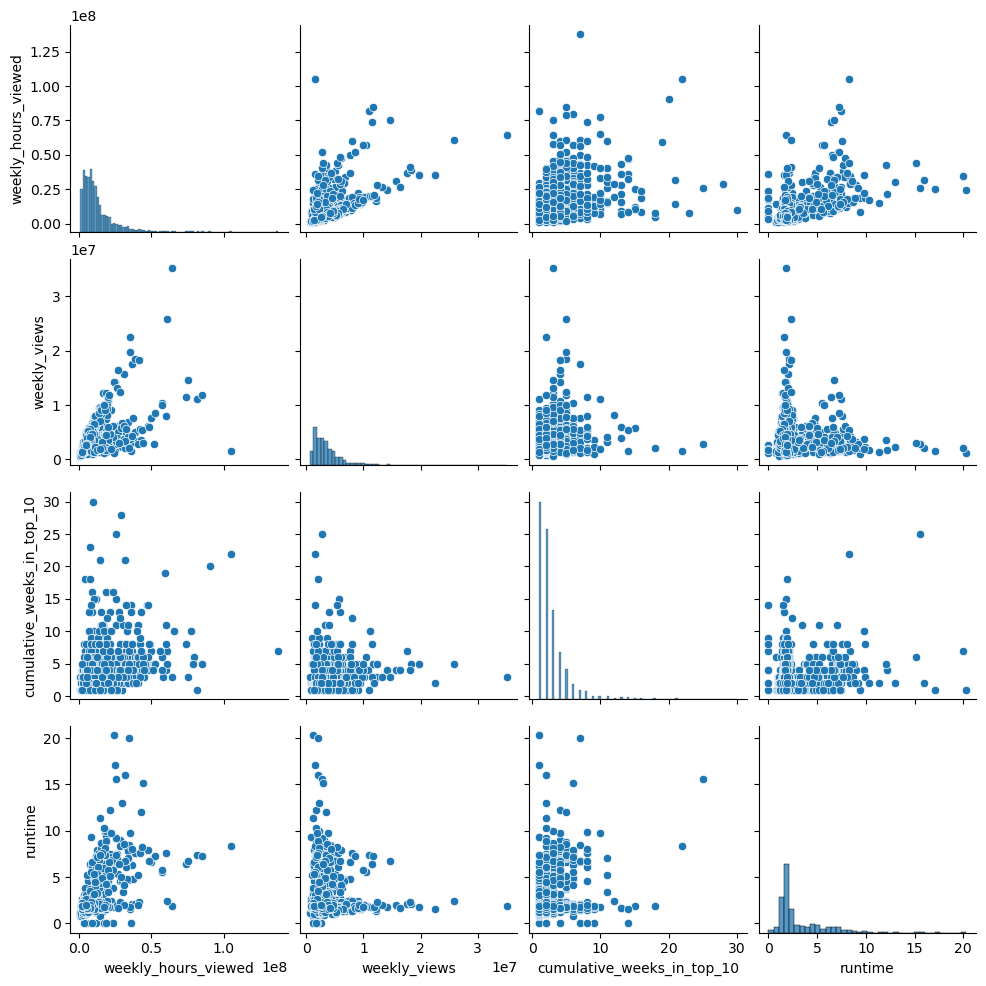

In [16]:
import seaborn as sns
sns.pairplot(grouped_df[['weekly_hours_viewed', 'weekly_views', 'cumulative_weeks_in_top_10', 'runtime']])
plt.show()

The pair plot analysis reveals left-skewed distributions across all variables and crowded scatter plots with a prevalent trend towards higher values. While a slight upwards trend suggests positive correlations between some variables, the overall presentation lacks clarity, indicating complex interactions within the data. Further investigation is needed to uncover underlying patterns.

### Type

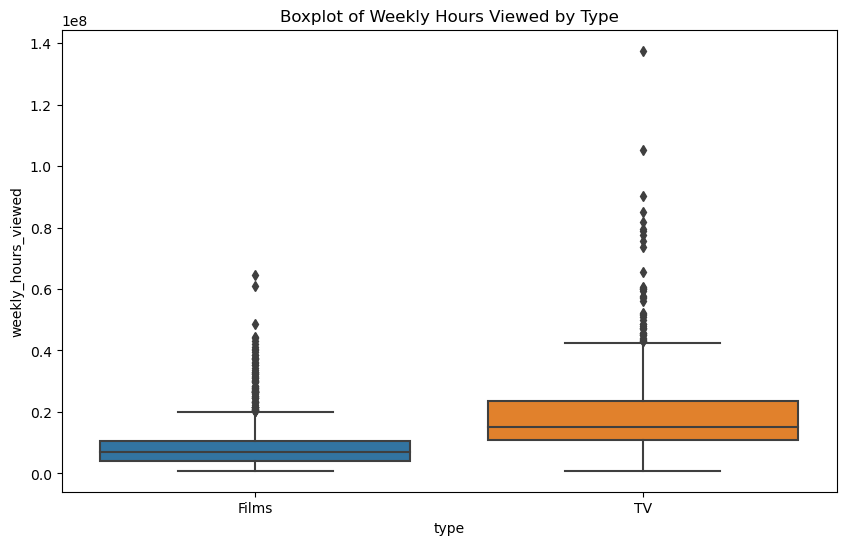

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='weekly_hours_viewed', data=grouped_df)
plt.title('Boxplot of Weekly Hours Viewed by Type')
plt.show()

Weekly hours viewed is more variable in the TV case, there is a larger range. Importantly, we can see that for both types, there are various outliers.

### Views

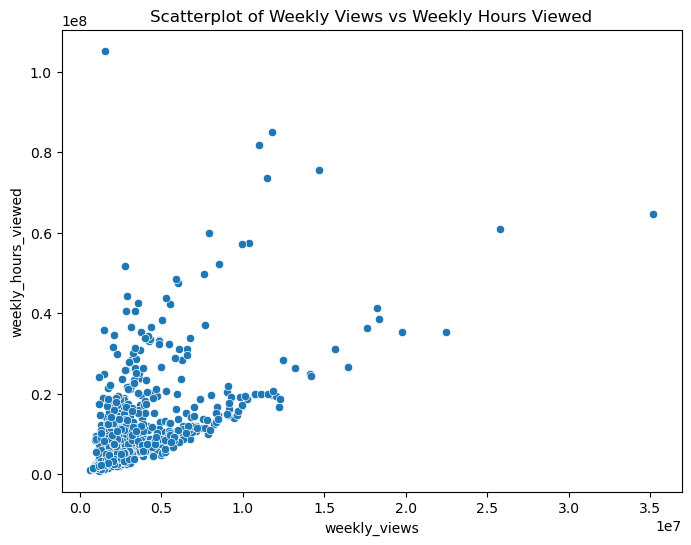

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='weekly_views', y='weekly_hours_viewed', data=grouped_df)
plt.title('Scatterplot of Weekly Views vs Weekly Hours Viewed')
plt.show()

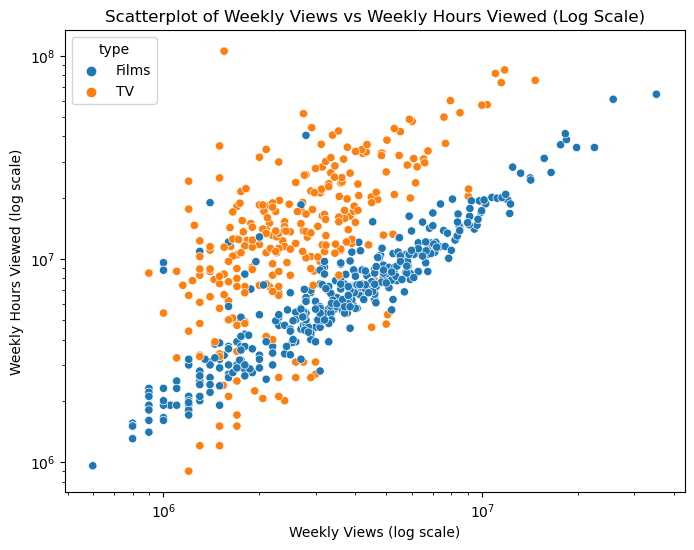

In [23]:
#Applying log scale for above^
plt.figure(figsize=(8, 6))
sns.scatterplot(x='weekly_views', y='weekly_hours_viewed', hue='type', data=grouped_df)
plt.xscale('log') 
plt.yscale('log')  
plt.title('Scatterplot of Weekly Views vs Weekly Hours Viewed (Log Scale)')
plt.xlabel('Weekly Views (log scale)')
plt.ylabel('Weekly Hours Viewed (log scale)')
plt.show()

Applying a log scale to the scatterplot clarifies the visualization by reducing overcrowding. This adjustment unveils a distinct upward trend, indicating a consistent increase in weekly hours viewed with higher weekly view counts. Thus, the log scale enhances our understanding of the relationship between these variables.

The graph compares weekly views to weekly hours viewed, both on a logarithmic scale. Key observations:
- Correlation:
  - There appears to be a positive correlation between the number of weekly views and the corresponding weekly hours viewed.
  - As the number of views increases, the hours viewed also tend to increase.
  - This correlation holds true for both films and TV content.
- Dense Clustering for TV:
  - There is a dense clustering of TV data points towards the higher end of both axes.
  - This suggests that TV content tends to have higher engagement (more hours viewed) relative to the number of views.


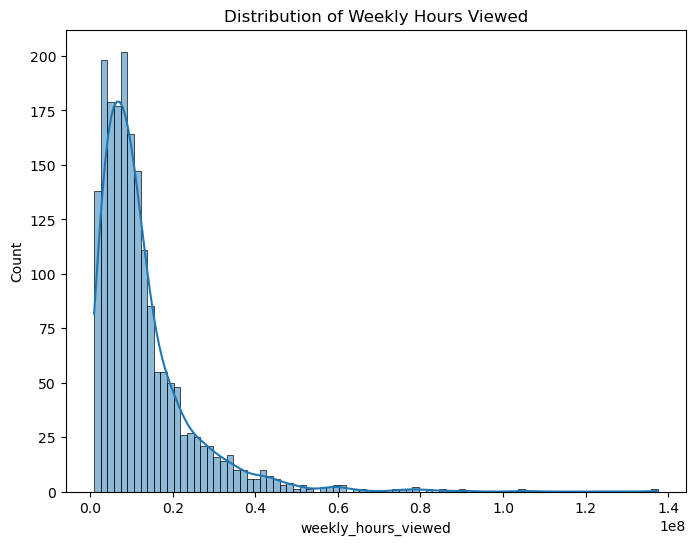

In [19]:
plt.figure(figsize=(8, 6))
sns.histplot(grouped_df['weekly_hours_viewed'], kde=True)
plt.title('Distribution of Weekly Hours Viewed')
plt.show()

### Language

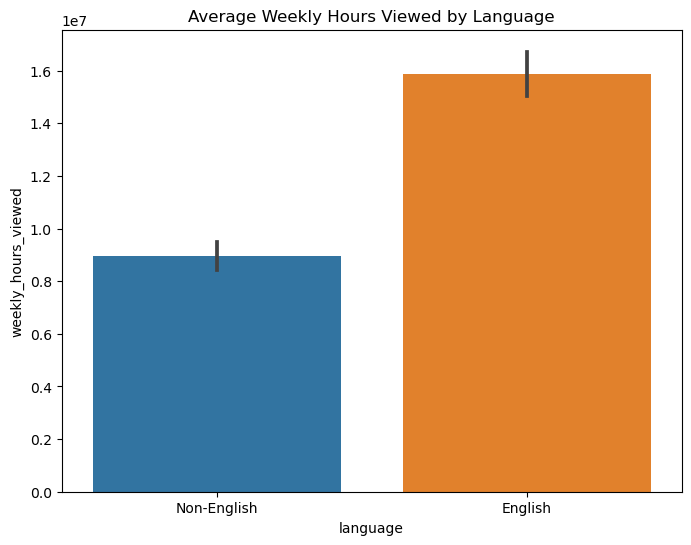

In [22]:
plt.figure(figsize=(8, 6))
sns.barplot(x='language', y='weekly_hours_viewed', data=grouped_df)
plt.title('Average Weekly Hours Viewed by Language')
plt.show()

English content tends to have higher average weekly hours views